### Данная тетрадка подготовлена Степаном Зиминым (tg @smzimin) и используется с его согласия. 

# Volatility modeling

## Content

- Data
    - Upload and visualize data
    - Preprocess prices and transform to returns
    - Plot histograms and Q-Q plots
    
    
- Modelling volatility
    - GARCH
    - Filtered HS
    
    
- Calculating VaR curve using volatility models
    - Filtered Historical Simulation
    - Parametric estimation
    
    
- Backtesting VaR curve
    - Bernoulli coverage test
    - Independence test
    
    
    
## References
- [Univariate Volatility Modeling](https://www.financialriskforecasting.com/files/Danielsson-Financial-Risk-Forecasting-Slides-2.pdf)


In [1]:
import numpy as np
import pandas as pd
from datetime import datetime

import scipy.stats as ss

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("bmh")
plt.rcParams['font.family'] = 'DejaVu Sans'

import warnings
warnings.filterwarnings("ignore")

## Data

### Upload and visualize data

**Task: download daily data for any company you want, so that you have at least 2 years of history**

In [2]:
# prices = pd.read_csv("apple.csv", decimal=",")
# prices = prices.loc[:, ("Дата", 'Цена')].rename(columns={
#     'Дата': "Date",
#     'Цена': "Price"
# })

# prices = prices.set_index('Date')
# prices

In [2]:
import yfinance as yf
ticker = 'BA'
prices = yf.download(ticker,'2010-01-01','2024-04-22')

prices.head()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['BA']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,BA,BA,BA,BA,BA,BA
Date,,,,,,


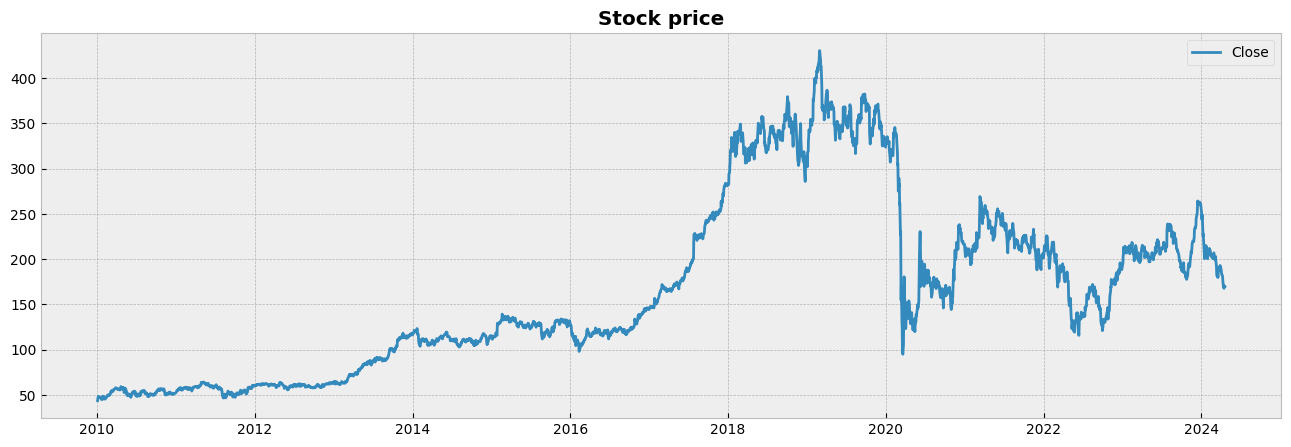

In [4]:
plot_fields =  ['Close']

fig = plt.figure(figsize=(16, 5))

plt.plot(prices[plot_fields])
plt.legend(plot_fields)

plt.title("Stock price", weight="bold")

plt.show()

### Preprocess prices and transform to returns

In [5]:


price = prices['Close']
ret = price.pct_change()
ret = ret.dropna()

ret

Ticker,BA
Date,
2010-01-05,0.032752
2010-01-06,0.030334
2010-01-07,0.040482
2010-01-08,-0.009646
2010-01-11,-0.011850
...,...
2024-04-15,-0.010203
2024-04-16,0.016267
2024-04-17,-0.001994


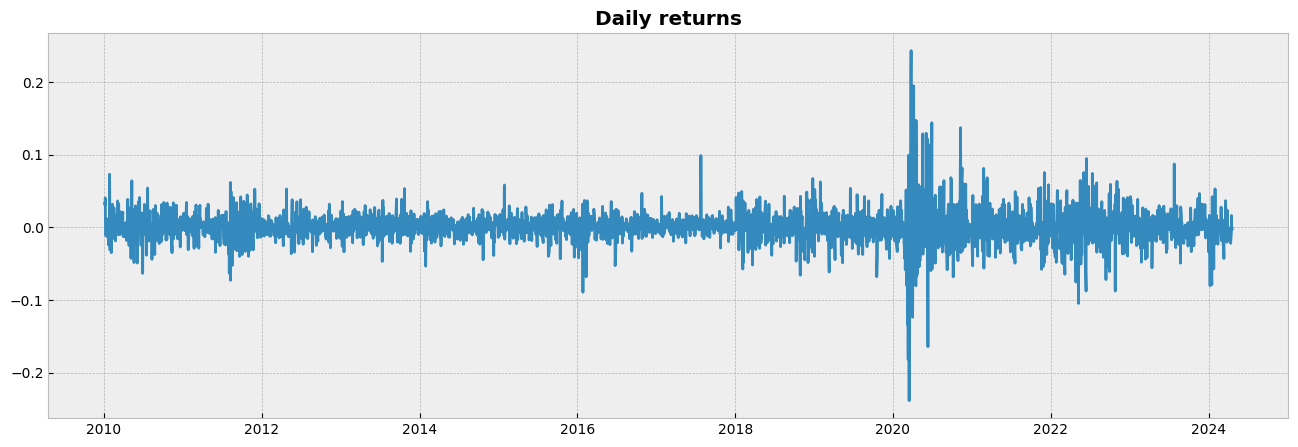

In [6]:
fig = plt.figure(figsize=(16, 5))


plt.plot(ret[ticker])
plt.title("Daily returns", weight="bold")

plt.show()

In [7]:
ret

Ticker,BA
Date,
2010-01-05,0.032752
2010-01-06,0.030334
2010-01-07,0.040482
2010-01-08,-0.009646
2010-01-11,-0.011850
...,...
2024-04-15,-0.010203
2024-04-16,0.016267
2024-04-17,-0.001994


### Plot histograms and Q-Q plots

Explore the Returns Distribution

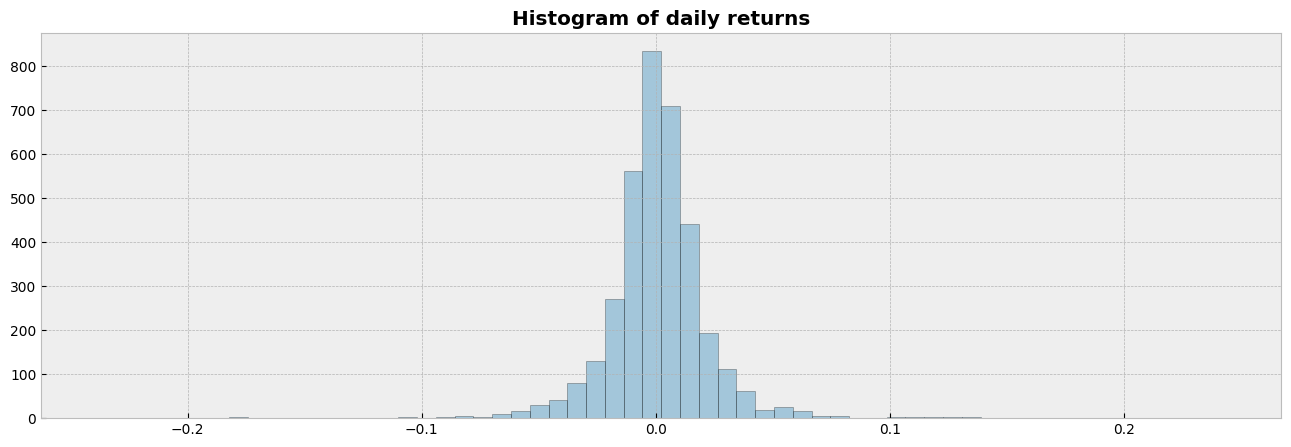

In [8]:
fig = plt.figure(figsize=(16, 5))

sns.distplot(ret, hist=True,
             kde=False, 
             bins=60,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

plt.title("Histogram of daily returns", weight="bold")

plt.show()

In [9]:
alpha = 0.05

## Recap -- Historical Simulation

In [10]:
from tqdm import trange

def calculate_VaR_HS(ret, alpha=0.05):

    return ret.quantile(alpha)

def calc_VaR(r, VaR_fun, L_history=252, level=0.05):
    VaR = np.full(r.size, np.nan)
    
    for i in trange(L_history, len(r)):
        history = r[i - L_history: i]
        VaR[i] = VaR_fun(history, level)
        
    return pd.Series(data=VaR, index=r.index, name=VaR_fun.__name__)

In [11]:
VaR_HS = calc_VaR(ret, calculate_VaR_HS, L_history=252, level=alpha)

VaR_HS

100%|██████████| 3345/3345 [00:00<00:00, 5040.86it/s]


Date
2010-01-05         NaN
2010-01-06         NaN
2010-01-07         NaN
2010-01-08         NaN
2010-01-11         NaN
                ...   
2024-04-15   -0.026689
2024-04-16   -0.026689
2024-04-17   -0.025545
2024-04-18   -0.025545
2024-04-19   -0.025545
Name: calculate_VaR_HS, Length: 3597, dtype: float64

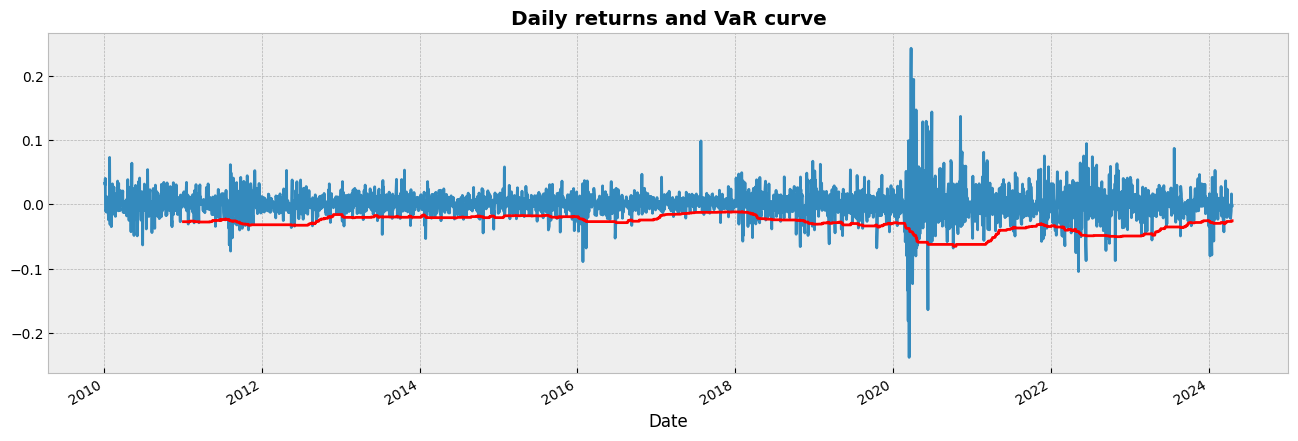

In [12]:
fig = plt.figure(figsize=(16, 5))

plt.plot(ret[ticker])
VaR_HS.plot(color='r')

plt.title("Daily returns and VaR curve", weight="bold")

plt.show()

## Volatility

### Simple case of Moving average estimation

Conditional volatility is the average sum of squared returns over the estimation window:

$$\hat{\sigma_{t}^2} = \frac{1}{W_e}\sum_{k=1}^{W_e}r_{t-k}^2$$

**Task: estimate variance using moving average with estimation window of 30 days**

Make `variance_ma` a pd.Series object for visualization

In [13]:
w_est = 35

variance_ma = np.full(ret.size, np.nan)

for i in range(w_est, len(ret)):
    history = ret[i-w_est: i]

    variance_ma[i] = np.sum(history ** 2) / w_est

variance_ma = pd.Series(variance_ma, index = ret.index)

In [14]:
variance_ma

Date
2010-01-05         NaN
2010-01-06         NaN
2010-01-07         NaN
2010-01-08         NaN
2010-01-11         NaN
                ...   
2024-04-15    0.000283
2024-04-16    0.000286
2024-04-17    0.000293
2024-04-18    0.000293
2024-04-19    0.000271
Length: 3597, dtype: float64

<Axes: xlabel='Date'>

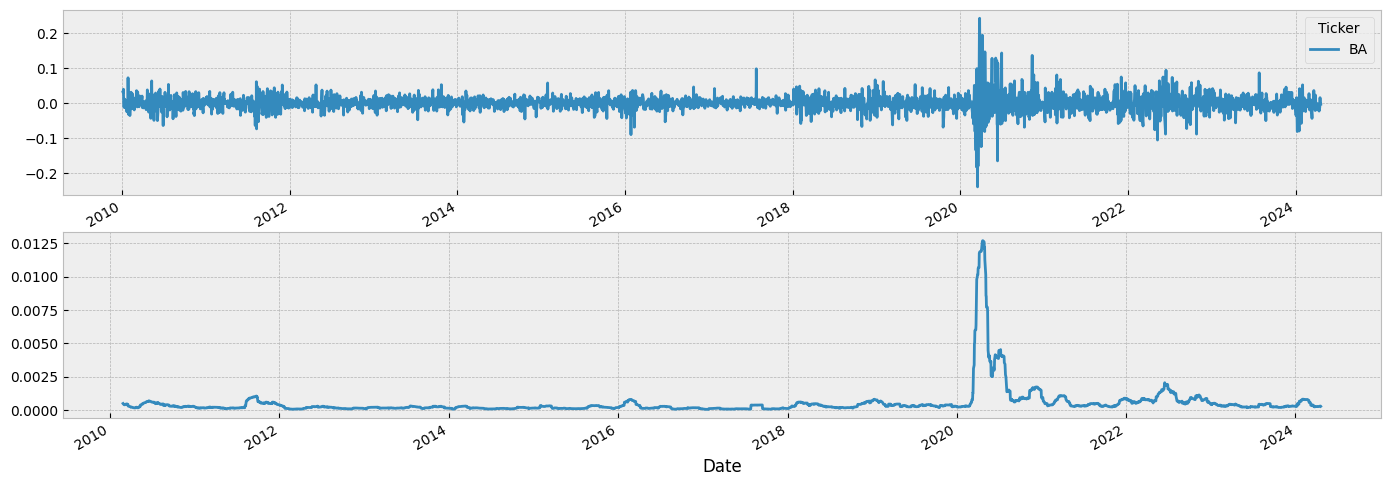

In [15]:
fig = plt.figure(figsize=(17,6))

plt1 = fig.add_subplot(2,1,1)
plt2 = fig.add_subplot(2,1,2)

ret.plot(ax=plt1.axes)

variance_ma.plot(ax=plt2.axes)

### GARCH models

And here we start assuming dependency between $r_t$ and $r_{t+h}$, and we will use Conditional volatility models. Facts motivating these models:
1. Returns are not linearly autocorrelated
2. The ACF of squared returns dies out exponentially
3. Volatility is time-varying

Main assumption: Conditional returns are iid normally distributed with time-varying variance

$$r_{t+1} = \mu_t  + \sqrt{h_t}\epsilon_t \text{  with  } \epsilon_t \sim N(0, 1)$$

$$\mu_{t+1} = F(r_t, r_{t-1}, ...)$$

$$h_{t+1} = G(r^2_t, r^2_{t-1}, ...)$$


For example, ARMA-GARCH model could be written as:

$$\mu_{t+1} = a + \sum_0^k c_ir_{t-i} + \sum_0^m d_i\epsilon_{t-i}$$

$$h_{t+1} = \omega + \sum_0^p \alpha_ir^2_{t-i} + \sum_0^q \beta_ih_{t-i}$$


Also, $\epsilon_t$ can have some other distribution $\epsilon_t \sim F(x; \theta)$


$$r_{t+1} \sim \mu_{t+1}  + \sqrt{h_{t+1}} \epsilon_t$$


#### GARCH with parametric distribution of residuals

I ecourage you too look at the following pages with formulas
- https://arch.readthedocs.io/en/latest/univariate/univariate_volatility_modeling.html
- https://arch.readthedocs.io/en/latest/univariate/forecasting.html

In [16]:
# https://arch.readthedocs.io/en/latest/univariate/introduction.html
# !pip install arch

In [17]:
from arch import arch_model

help(arch_model)

Help on function arch_model in module arch.univariate.mean:

arch_model(y: Union[numpy.ndarray, pandas.core.frame.DataFrame, pandas.core.series.Series, NoneType], x: Union[numpy.ndarray, pandas.core.frame.DataFrame, NoneType] = None, mean: Literal['Constant', 'Zero', 'LS', 'AR', 'ARX', 'HAR', 'HARX', 'constant', 'zero'] = 'Constant', lags: Union[int, list[int], numpy.ndarray[Any, numpy.dtype[numpy.int32]], numpy.ndarray[Any, numpy.dtype[numpy.longlong]], NoneType] = 0, vol: Literal['GARCH', 'ARCH', 'EGARCH', 'FIGARCH', 'APARCH', 'HARCH'] = 'GARCH', p: Union[int, list[int]] = 1, o: int = 0, q: int = 1, power: float = 2.0, dist: Literal['normal', 'gaussian', 't', 'studentst', 'skewstudent', 'skewt', 'ged', 'generalized error'] = 'normal', hold_back: Optional[int] = None, rescale: Optional[bool] = None) -> arch.univariate.mean.HARX
    Initialization of common ARCH model specifications
    
    Parameters
    ----------
    y : ndarray, Series, None
        The dependent variable
    x : 



**Task: Fit a default model without any params**

Note: for numerical optimization purposes, it is better to scale your returns series to a scale of one. Don't forget to re-scale it after

For simplicity now, just pass returns multiplied by 100

In [18]:
ret * 100

Ticker,BA
Date,
2010-01-05,3.275186
2010-01-06,3.033442
2010-01-07,4.048176
2010-01-08,-0.964635
2010-01-11,-1.185035
...,...
2024-04-15,-1.020345
2024-04-16,1.626740
2024-04-17,-0.199353


In [19]:
from arch import arch_model

model = arch_model(100*ret)
res = model.fit()

res

Iteration:      1,   Func. Count:      6,   Neg. LLF: 155796376221.3816
Iteration:      2,   Func. Count:     14,   Neg. LLF: 5767651259.074355
Iteration:      3,   Func. Count:     22,   Neg. LLF: 899317652.6278837
Iteration:      4,   Func. Count:     28,   Neg. LLF: 7191.945264191661
Iteration:      5,   Func. Count:     34,   Neg. LLF: 8409.424495761445
Iteration:      6,   Func. Count:     41,   Neg. LLF: 7185.40248581776
Iteration:      7,   Func. Count:     47,   Neg. LLF: 7169.990118033681
Iteration:      8,   Func. Count:     52,   Neg. LLF: 7169.9871170601555
Iteration:      9,   Func. Count:     57,   Neg. LLF: 7169.987079676914
Iteration:     10,   Func. Count:     62,   Neg. LLF: 7169.987078743614
Optimization terminated successfully    (Exit mode 0)
            Current function value: 7169.987078743614
            Iterations: 10
            Function evaluations: 62
            Gradient evaluations: 10


                     Constant Mean - GARCH Model Results                      
Dep. Variable:                     BA   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -7169.99
Distribution:                  Normal   AIC:                           14348.0
Method:            Maximum Likelihood   BIC:                           14372.7
                                        No. Observations:                 3597
Date:                Sat, Apr 26 2025   Df Residuals:                     3596
Time:                        17:16:59   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0949  2.540e-02      3.736  1.870e-04 [4.512e-0

**Task: Play with parameters and print results again**

You can use:
- `mean` and `lags` -- to specify model for mean
- `vol`, `p`, `q` and `o` -- to specify model for variance
- `dist` -- to specify distribution for normalized residuals

In [20]:

model = arch_model(
    y=100 * ret,
    mean='AR', lags=2,
    vol='GARCH',
    dist='ged'
)

res = model.fit()

res

Iteration:      1,   Func. Count:      9,   Neg. LLF: 35274687.93121889
Iteration:      2,   Func. Count:     21,   Neg. LLF: 20620090.285901923
Iteration:      3,   Func. Count:     32,   Neg. LLF: 22550589.594613373
Iteration:      4,   Func. Count:     43,   Neg. LLF: 22080070.141400583
Iteration:      5,   Func. Count:     54,   Neg. LLF: 2525306.1291480362
Iteration:      6,   Func. Count:     63,   Neg. LLF: 7057.27865258181
Iteration:      7,   Func. Count:     72,   Neg. LLF: 7813.5901721493165
Iteration:      8,   Func. Count:     81,   Neg. LLF: 7079.040397486024
Iteration:      9,   Func. Count:     90,   Neg. LLF: 7140.889713519751
Iteration:     10,   Func. Count:     99,   Neg. LLF: 4627985.514231944
Iteration:     11,   Func. Count:    108,   Neg. LLF: 7012.420445324744
Iteration:     12,   Func. Count:    116,   Neg. LLF: 7011.539621745054
Iteration:     13,   Func. Count:    124,   Neg. LLF: 7011.384123949547
Iteration:     14,   Func. Count:    132,   Neg. LLF: 7011.4

                                 AR - GARCH Model Results                                 
Dep. Variable:                                 BA   R-squared:                      -0.001
Mean Model:                                    AR   Adj. R-squared:                 -0.002
Vol Model:                                  GARCH   Log-Likelihood:               -7011.37
Distribution:      Generalized Error Distribution   AIC:                           14036.7
Method:                        Maximum Likelihood   BIC:                           14080.0
                                                    No. Observations:                 3595
Date:                            Sat, Apr 26 2025   Df Residuals:                     3592
Time:                                    17:17:00   Df Model:                            3
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-------------------------

Here is the previous result for moving average. Now compare with GARCH results below.

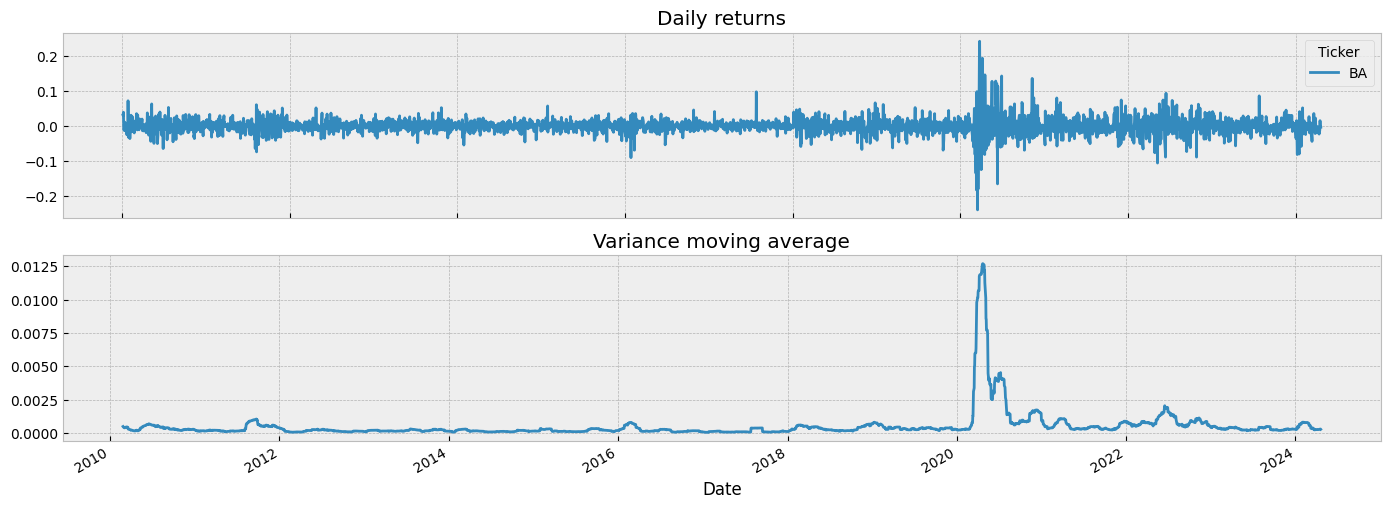

In [21]:
fig = plt.figure(figsize=(17, 6))

plt1 = fig.add_subplot(2,1,1)
plt2 = fig.add_subplot(2,1,2)

ret.plot(ax=plt1.axes)
plt1.set_title('Daily returns')

variance_ma.plot(ax=plt2.axes)
plt2.set_title('Variance moving average')

for ax in fig.get_axes():
    ax.label_outer()

plt.show()

Here we can see fitted conditional volatility and standartized residuals

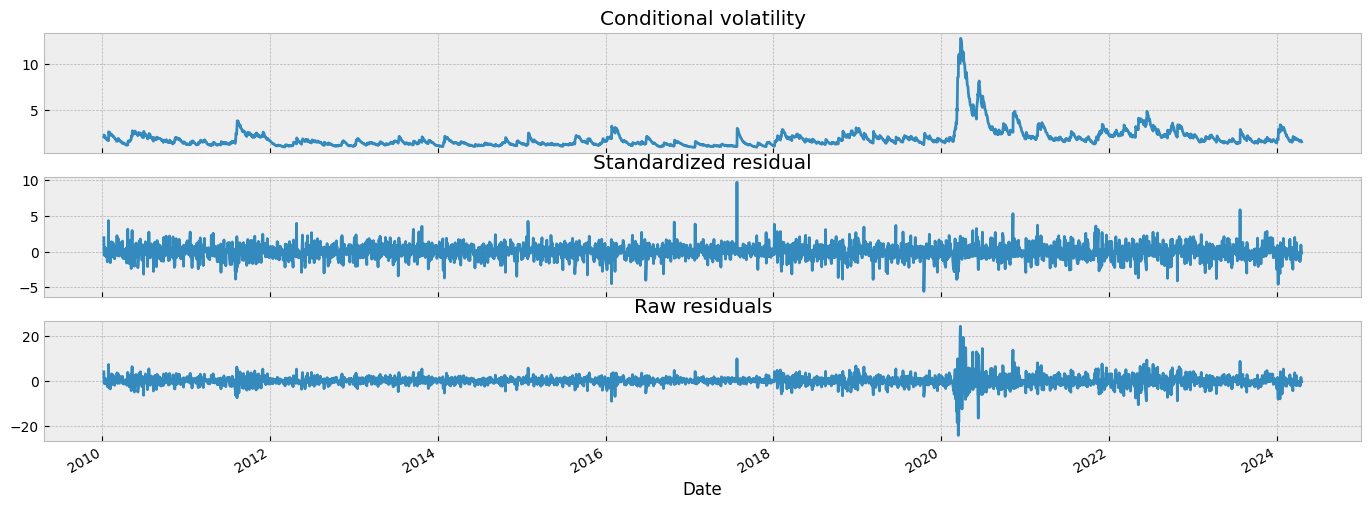

In [22]:
fig = plt.figure(figsize=(17, 6))

plt1 = fig.add_subplot(3,1,1)
plt2 = fig.add_subplot(3,1,2)
plt3 = fig.add_subplot(3,1,3)


res.conditional_volatility.plot(ax=plt1.axes)
plt1.set_title('Conditional volatility')

(res.resid / res.conditional_volatility).plot(ax=plt2.axes)
plt2.set_title('Standardized residual')

res.resid.plot(ax=plt3.axes)
plt3.set_title('Raw residuals')

for ax in fig.get_axes():
    ax.label_outer()

plt.show()

**Learn how to do forecast of conditional mean and variance**

In [23]:
my_forecast = res.forecast(horizon=5)

print(my_forecast.mean.tail(4))
print(my_forecast.variance.tail(4))

                 h.1       h.2       h.3       h.4       h.5
Date                                                        
2024-04-19  0.089214  0.093937  0.090609  0.090539  0.090573
                 h.1       h.2       h.3       h.4       h.5
Date                                                        
2024-04-19  2.228645  2.257447  2.285913  2.313691  2.341013


**Check and interpret probability plot**

((array([-4.82104462, -4.34969255, -4.09776932, ...,  4.09776932,
          4.34969255,  4.82104462]),
  array([-5.54757593, -4.54989325, -4.47823901, ...,  5.2664442 ,
          5.80519145,  9.63785413])),
 (np.float64(1.007764212317699),
  np.float64(-0.017621731716358526),
  np.float64(0.9952273451221977)))

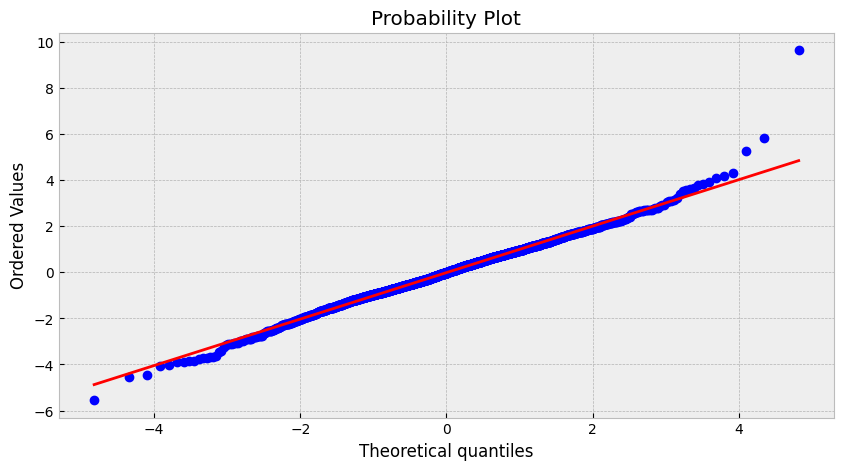

In [24]:
fig = plt.figure(figsize=(10, 5))

ss.probplot(
    (res.resid / res.conditional_volatility).dropna(),
    dist=model.distribution,
    sparams=(res.params[-1:], ),
    plot=plt
)

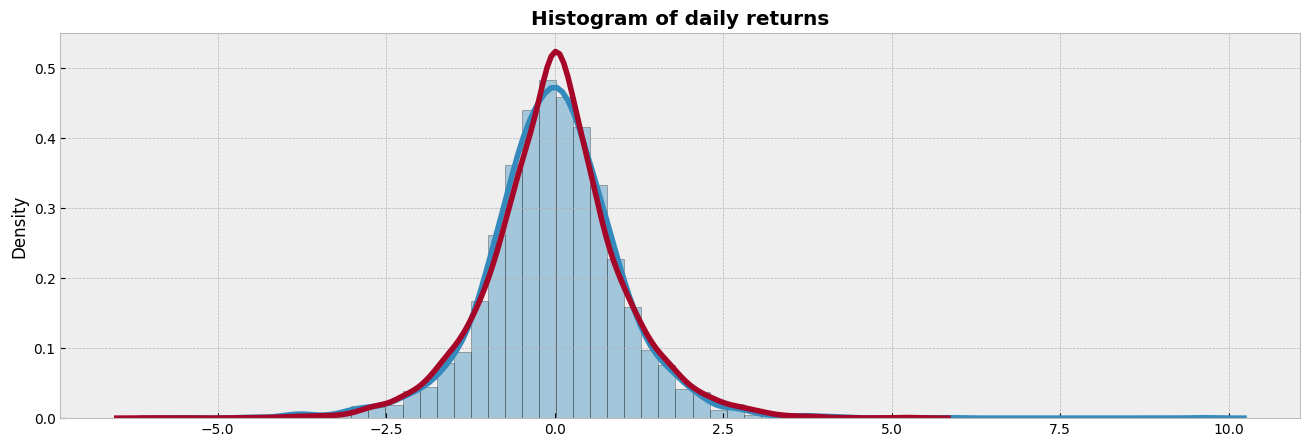

In [25]:


fig = plt.figure(figsize=(16, 5))

x = np.linspace(ret.min(), ret.max(), 200)

std_resid = (res.resid / res.conditional_volatility).dropna()
sns.distplot(std_resid, hist=True, kde=True, 
             bins=60,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

y_pdf = model.distribution.simulate(parameters=res.params[-1:])(size=10000)
sns.distplot(y_pdf, hist=False, kde=True, 
             bins=60,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

plt.title("Histogram of daily returns", weight="bold")

plt.show()

**Task: Inplement Filtered Historical Simulation**

Steps:
- fit a model
- get Standartized residuals
- forecast mean and variance one step ahead
- use forecasts and Standartized residuals to get a distribution for Conditional residuals
- calculate VaR as quantile

In [26]:
dist = 'skewstudent'

mdl = arch_model(
    y=100 * ret,
    mean='HARX', lags=1, # mean = Constant, ARX, HARX + the number of lags
    vol='Garch', p=1, o=1, q=1, # vol = Garch, EGARCH, HARCH + the number of lags
    dist=dist # dist = Normal, t, skewstudent, ged
) 

res = mdl.fit()

stand_residuals = (res.resid / res.conditional_volatility).dropna()
forecasts = res.forecast(horizon=1)
cond_mean = float(forecasts.mean.iloc[-1])
cond_var = float(forecasts.variance.iloc[-1])


# Option 1
conditional_sr  = (stand_residuals * np.sqrt(cond_var)) + cond_mean
conditional_sr = conditional_sr / 100

VaR_FHS = conditional_sr.quantile(alpha)

print(VaR_FHS)
# Option 2

quant = stand_residuals.quantile(alpha)
cond_quant = (quant * np.sqrt(cond_var)) + cond_mean
VaR_FHS = cond_quant / 100
print(VaR_FHS)

# Option 3
quant = np.quantile(mdl.distribution.simulate(parameters=res.params[-2:])(size=10000), alpha)
cond_quant = (quant * np.sqrt(cond_var)) + cond_mean
VaR_FHS = cond_quant / 100

print(VaR_FHS)

# Option 4
quant = mdl.distribution.ppf(alpha, res.params[-2:])
cond_quant = (quant * np.sqrt(cond_var)) + cond_mean
VaR_FHS = cond_quant / 100
print(VaR_FHS)

Iteration:      1,   Func. Count:     10,   Neg. LLF: 198435.4680056281
Iteration:      2,   Func. Count:     23,   Neg. LLF: 79771.4428952107
Iteration:      3,   Func. Count:     35,   Neg. LLF: 522098.8249085367
Iteration:      4,   Func. Count:     47,   Neg. LLF: 143416.73739007086
Iteration:      5,   Func. Count:     58,   Neg. LLF: 10108.812044589822
Iteration:      6,   Func. Count:     68,   Neg. LLF: 7092.996920499939
Iteration:      7,   Func. Count:     78,   Neg. LLF: 8867.762028097404
Iteration:      8,   Func. Count:     90,   Neg. LLF: 7003.8149608701215
Iteration:      9,   Func. Count:    100,   Neg. LLF: 6981.4532013495245
Iteration:     10,   Func. Count:    110,   Neg. LLF: 7004.136390270515
Iteration:     11,   Func. Count:    121,   Neg. LLF: 6988.449065077728
Iteration:     12,   Func. Count:    131,   Neg. LLF: 6977.654941300214
Iteration:     13,   Func. Count:    140,   Neg. LLF: 6977.646341756799
Iteration:     14,   Func. Count:    149,   Neg. LLF: 6977.64

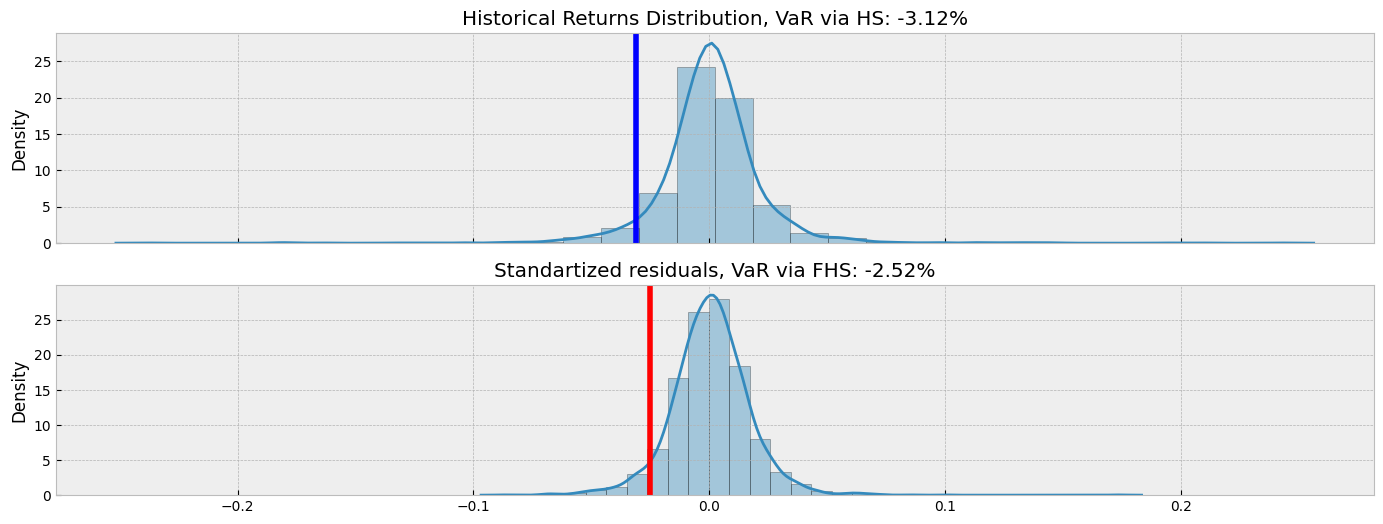

In [27]:
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(17, 6))

VaR_HS_10 = np.quantile(ret, alpha)

sns.distplot(ret, hist=True, kde=True, 
             bins=30, norm_hist=True,
             hist_kws={'edgecolor':'black'}, ax=ax[0])
ax[0].set_title('Historical Returns Distribution, VaR via HS: {:.2f}%'.format(100*VaR_HS_10))
ax[0].axvline(x=VaR_HS_10, linewidth=4, color="b")

sns.distplot(conditional_sr, hist=True, kde=True, 
             bins=30, norm_hist=True,
             hist_kws={'edgecolor':'black'}, ax=ax[1])
ax[1].set_title('Standartized residuals, VaR via FHS: {:.2f}%'.format(100*VaR_FHS))
ax[1].axvline(x=VaR_FHS, linewidth=4, color="r")

for ax in fig.get_axes():
    ax.label_outer()

plt.show()

**Task: Wrap everything into functions and do a backtest**

In [67]:
def calculate_VaR_garch(returns, alpha):
    
    scaling_const = 10.0 / returns.std()

    dist = 'ged'
    am = arch_model(scaling_const * returns,
                    mean='HARX', lags=1, # mean = Constant, ARX, HARX + the number of lags
                    vol='Garch', p=1, o=1, q=1, # vol = Garch, EGARCH, HARCH + the number of lags
                    dist=dist) # dist = Normal, t, skewstudent, ged

    res = am.fit(disp='off')

    forecasts = res.forecast(horizon=1)
    cond_mean = float(forecasts.mean.iloc[-1])
    cond_var = float(forecasts.variance.iloc[-1])

    match dist:

        case 'Normal':
            q = am.distribution.ppf(alpha)

        case 't' | 'ged':
            q = am.distribution.ppf(alpha, res.params[-1:])

        case 'skewstudent':
            q = am.distribution.ppf(alpha, res.params[-2:])

    VaR_garch_forecast = (cond_mean + np.sqrt(cond_var) * q) / scaling_const
   
    return VaR_garch_forecast


def calculate_VaR_FHS(returns, alpha):
    
    scaling_const = float(10.0 / returns.std())

    mdl = arch_model(scaling_const * returns,
                    mean='HARX', lags=1, # mean = Constant, ARX, HARX + the number of lags
                    vol='Garch', p=1, o=1, q=1, # vol = Garch, EGARCH, HARCH + the number of lags
                    dist='ged')

    res = mdl.fit(disp='off')

    stand_residuals = (res.resid / res.conditional_volatility).dropna()

    
    forecasts = res.forecast(horizon=1)
    cond_mean = float(forecasts.mean.iloc[-1])
    cond_var = float(forecasts.variance.iloc[-1])

    conditional_sr  = (stand_residuals * np.sqrt(cond_var)) + cond_mean
    conditional_sr = conditional_sr / scaling_const

    VaR_FHS = conditional_sr.quantile(alpha)

    return VaR_FHS

In [68]:
VaR_FHS = calc_VaR(ret, calculate_VaR_FHS, L_history=252, level=alpha)

100%|██████████| 3345/3345 [01:24<00:00, 39.58it/s]


In [69]:
VaR_garch = calc_VaR(ret, calculate_VaR_garch, L_history=252, level=alpha)


100%|██████████| 3345/3345 [01:27<00:00, 38.31it/s]


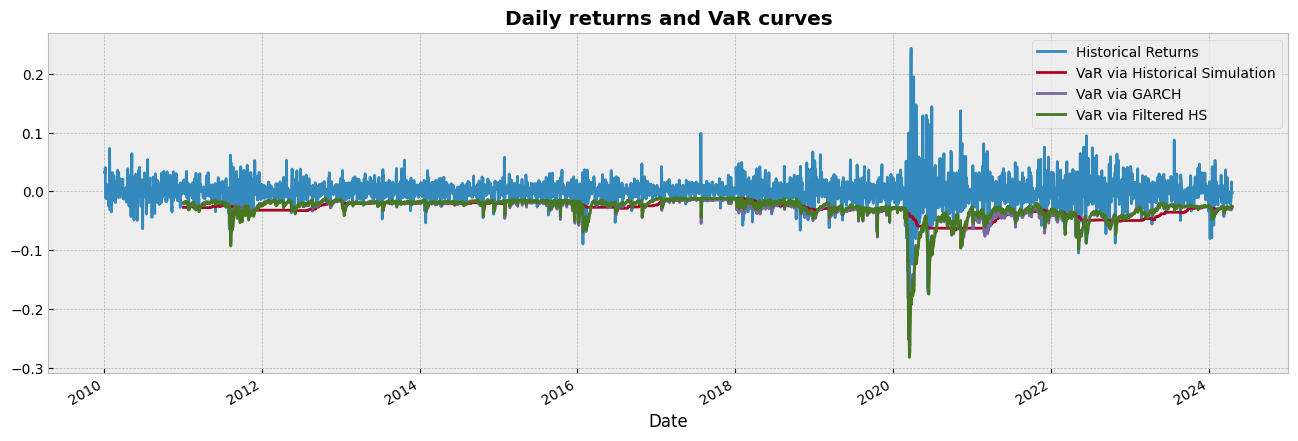

In [70]:
fig = plt.figure(figsize=(16, 5))

plt.plot(ret[ticker])
VaR_HS.plot()
# VaR_t.plot()
VaR_garch.plot()
VaR_FHS.plot()

plt.title("Daily returns and VaR curves", weight="bold")

plt.legend(['Historical Returns',
            'VaR via Historical Simulation',
           'VaR via GARCH',
           'VaR via Filtered HS'
           ])

plt.show()

## Backtesting VaR

In [71]:
def bern_test(p, v):
    
    lv = len(v)
    sv = sum(v)
    al = np.log(p)*sv + np.log(1-p)*(lv-sv)
    
    bl = np.log(sv/lv)*sv + np.log(1-sv/lv)*(lv-sv)
    
    return (-2*(al-bl))


def ind_test(V):
    
    J = np.full([len(V),4], 0)
    for i in range(1,len(V)-1):
        J[i,0] = (V[i-1] == 0) & (V[i] == 0)
        J[i,1] = (V[i-1] == 0) & (V[i] == 1)
        J[i,2] = (V[i-1] == 1) & (V[i] == 0)
        J[i,3] = (V[i-1] == 1) & (V[i] == 1)
        
    V_00 = sum(J[:,0])
    V_01 = sum(J[:,1])
    V_10 = sum(J[:,2])
    V_11 = sum(J[:,3])
    p_00=V_00/(V_00+V_01)
    p_01=V_01/(V_00+V_01)
    p_10=V_10/(V_10+V_11)
    p_11=V_11/(V_10+V_11)
    hat_p = (V_01+V_11)/(V_00+V_01+V_10+V_11)
    al = np.log(1-hat_p)*(V_00+V_10) + np.log(hat_p)*(V_01+V_11)
    bl = np.log(p_00)*V_00 + np.log(p_01)*V_01 + np.log(p_10)*V_10 + np.log(p_11)*V_11
    
    return (-2*(al-bl))

In [72]:
def backtest_results(ret, var_curve, alpha, significance=0.95):
    
    idx = var_curve.notna()
    
    violations = ret[idx] < var_curve[idx]
    
    coverage = bern_test(p=alpha, v=violations) < ss.chi2.ppf(significance, 1)
    independence = ind_test(violations) < ss.chi2.ppf(significance, 1)
        
    print('Target share of violations: {:.2f}%'.format(100*alpha))
    print('Observed share of violations: {:.2f}%'.format(100*violations.mean()))
    
    print('')
    
    if coverage:
        print('Test for coverage is passed')
    else:
        print('Test for coverage isn\'t passed')
        
    print('')
        
    if independence:
        print('Test for independence is passed')
    else:
        print('Test for independence isn\'t passed')

In [73]:
backtest_results(
    ret[ticker], 
    var_curve=VaR_HS,
    alpha=alpha, 
    significance=0.95
)

Target share of violations: 5.00%
Observed share of violations: 5.62%

Test for coverage is passed

Test for independence isn't passed


In [74]:
backtest_results(
    ret[ticker], 
    var_curve=VaR_garch,
    alpha=alpha, 
    significance=0.95
)

Target share of violations: 5.00%
Observed share of violations: 5.32%

Test for coverage is passed

Test for independence is passed


In [75]:
backtest_results(
    ret[ticker], 
    var_curve=VaR_FHS,
    alpha=alpha, 
    significance=0.95
)

Target share of violations: 5.00%
Observed share of violations: 6.07%

Test for coverage isn't passed

Test for independence is passed
